<a href="https://colab.research.google.com/github/dubeyabhi07/big-data-spark/blob/master/src/main/pyspark/climate/climateZones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

!pip install pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

     |████████████████████████████████| 204.7MB 67kB/s 
     |████████████████████████████████| 204kB 45.6MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.0-py2.py3-none-any.whl size=205044182 sha256=a3b82a0890d80bdc7add65e022d8c07bddf8ade472e05aaa2bc4c375fff91953
  Stored in directory: /root/.cache/pip/wheels/57/27/4d/ddacf7143f8d5b76c45c61ee2e43d9f8492fc5a8e78ebd7d37
Successfully built pyspark


In [ ]:
!wget ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt

--2020-06-19 07:47:35--  ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt
           => ‘ghcnd-stations.txt’
Resolving ftp.ncdc.noaa.gov (ftp.ncdc.noaa.gov)... 205.167.25.137, 2610:20:8040:2::137
Connecting to ftp.ncdc.noaa.gov (ftp.ncdc.noaa.gov)|205.167.25.137|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/data/ghcn/daily ... done.
==> SIZE ghcnd-stations.txt ... 9897052
==> PASV ... done.    ==> RETR ghcnd-stations.txt ... done.
Length: 9897052 (9.4M) (unauthoritative)

ghcnd-stations.txt  100%[===================>]   9.44M  4.95MB/s    in 1.9s    

2020-06-19 07:47:40 (4.95 MB/s) - ‘ghcnd-stations.txt’ saved [9897052]



In [ ]:
#importing station-data

from pyspark.sql.functions import *
from pyspark.sql.types import *
schema = StructType([StructField('id', StringType(), True),
                     StructField('lat', DoubleType(), True),
                     StructField('long', DoubleType(), True),
                     StructField('elev', DoubleType(), True),
                     StructField('name', StringType(), True)])

stations=spark.sparkContext.textFile("ghcnd-stations.txt")
stations = stations.map(lambda k: [k[0:11].strip(),float(k[12:20].strip()),float(k[21:30].strip()),float(k[31:37].strip()),k[41:].strip()])
stations=stations.toDF(schema)
stations.show(5)


#clustering stations on the basis of geography (lat-long)

from pyspark.ml.feature import VectorAssembler
features = ('long','lat')   
assembler = VectorAssembler(inputCols=features,outputCol="geo_coordinate")
dataset=assembler.transform(stations)

from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans
# Trains a k-means model.(k>=2000 should be used, if adequate compute resourse is there)
kmeans = KMeans().setK(50).setSeed(10190).setFeaturesCol("geo_coordinate")
model = kmeans.fit(dataset)
# Make predictions
predictions = model.transform(dataset)
predictions.cache().show(5)

+-----------+-------+--------+----+--------------------+
|         id|    lat|    long|elev|                name|
+-----------+-------+--------+----+--------------------+
|ACW00011604|17.1167|-61.7833|10.1|ST JOHNS COOLIDGE...|
|ACW00011647|17.1333|-61.7833|19.2|            ST JOHNS|
|AE000041196| 25.333|  55.517|34.0|SHARJAH INTER. AI...|
|AEM00041194| 25.255|  55.364|10.4|DUBAI INTL       ...|
|AEM00041217| 24.433|  54.651|26.8|ABU DHABI INTL   ...|
+-----------+-------+--------+----+--------------------+
only showing top 5 rows

+-----------+-------+--------+----+--------------------+------------------+----------+
|         id|    lat|    long|elev|                name|    geo_coordinate|prediction|
+-----------+-------+--------+----+--------------------+------------------+----------+
|ACW00011604|17.1167|-61.7833|10.1|ST JOHNS COOLIDGE...|[-61.7833,17.1167]|        20|
|ACW00011647|17.1333|-61.7833|19.2|            ST JOHNS|[-61.7833,17.1333]|        20|
|AE000041196| 25.333|  55.5

In [ ]:
#observatory data

!wget ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/2019.csv.gz
!gzip -d 2019.csv.gz

schema = StructType([StructField('id', StringType(), True),
                     StructField('date', DateType(), True),
                     StructField('measure', StringType(), True),
                     StructField('value', DoubleType(), True),StructField('extra', StringType(), True)])


data = spark.read.csv("./2019.csv",schema=schema,dateFormat="yyyyMMdd")
data.show(5)

--2020-06-19 07:48:04--  ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/2019.csv.gz
           => ‘2019.csv.gz’
Resolving ftp.ncdc.noaa.gov (ftp.ncdc.noaa.gov)... 205.167.25.137, 2610:20:8040:2::137
Connecting to ftp.ncdc.noaa.gov (ftp.ncdc.noaa.gov)|205.167.25.137|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/data/ghcn/daily/by_year ... done.
==> SIZE 2019.csv.gz ... 205099059
==> PASV ... done.    ==> RETR 2019.csv.gz ... done.
Length: 205099059 (196M) (unauthoritative)

2019.csv.gz         100%[===================>] 195.60M  13.1MB/s    in 16s     

2020-06-19 07:48:23 (11.9 MB/s) - ‘2019.csv.gz’ saved [205099059]

+-----------+----------+-------+-----+-----+
|         id|      date|measure|value|extra|
+-----------+----------+-------+-----+-----+
|US1FLSL0019|2019-01-01|   PRCP|  0.0| null|
|US1FLSL0019|2019-01-01|   SNOW|  0.0| null|
|US1NVNY0012|2019-01-01|   PRCP|  0.0| null|
|US1NVNY0

In [ ]:
dataWithCluster = data.select("id","date","measure","value")\
.join(predictions,data['id']==predictions['id'])\
.select(data["id"],"date","measure","value",predictions["prediction"].alias("cluster"),"lat","long","elev").cache()
dataWithCluster.show(5)

+-----------+----------+-------+-----+-------+--------+--------+-----+
|         id|      date|measure|value|cluster|     lat|    long| elev|
+-----------+----------+-------+-----+-------+--------+--------+-----+
|ASN00008254|2019-01-01|   PRCP|  0.0|     18|-30.7092|116.7744|280.0|
|ASN00008254|2019-01-02|   PRCP|  0.0|     18|-30.7092|116.7744|280.0|
|ASN00008254|2019-01-03|   PRCP|  0.0|     18|-30.7092|116.7744|280.0|
|ASN00008254|2019-01-04|   PRCP|  0.0|     18|-30.7092|116.7744|280.0|
|ASN00008254|2019-01-05|   PRCP|  0.0|     18|-30.7092|116.7744|280.0|
+-----------+----------+-------+-----+-------+--------+--------+-----+
only showing top 5 rows



In [ ]:
tmaxs = dataWithCluster.filter(col("measure") == "TMAX").cache()
tmaxFeatures  = tmaxs.groupBy(col("cluster")).agg(avg(col("value")).alias("tmaxMean"), stddev(col("value")).alias("tmaxStd"))\
      .select("tmaxMean","tmaxStd","cluster")

tmins = dataWithCluster.filter(col("measure") == "TMIN").cache()
tminFeatures = tmins.groupBy(col("cluster")).agg(avg("value").alias("tminMean"), stddev(col("value")).alias("tminStd"))\
      .select("tminMean","tminStd","cluster")

precips = dataWithCluster.filter(col("measure") == "PRCP").cache()
precipFeature = precips.groupBy(col("cluster")).agg(avg(col("value")).alias("precip"))\
      .select("precip","cluster").cache()

featureDf = dataWithCluster.groupBy(col("cluster")).agg(avg(col("long")).alias("longMean"), stddev(col("long")).alias("longStd"),
                    avg(col("lat")).alias("latMean"), stddev(col("lat")).alias("latStd"))\
                    .select("cluster","latMean","latStd","longMean","longStd")
featureDf = featureDf.join(precipFeature,["cluster"]).join(tminFeatures,["cluster"]).join(tmaxFeatures,["cluster"]).cache()

featureDf.show(5)

                                                      

+-------+------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+
|cluster|           latMean|            latStd|           longMean|           longStd|            precip|           tminMean|           tminStd|          tmaxMean|           tmaxStd|
+-------+------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+
|     31|26.534379110728104| 5.228572992912691|  91.74504185244511| 5.641928253058893| 78.37891968440219| 132.67967198964178|126.02381147445256|245.39402571406575|115.90408516723473|
|     34|-36.51973799464292|18.535897247535214| 16.279854554994106|  8.06356063944032| 22.28014505893019|  73.53573948986794|150.49694018777697|225.03389174009877|176.48788973061593|
|     28| 51.26811379147094| 4.129097591732607|-114.95279988376666|3.2175035284339106

In [ ]:
import math
from pyspark.sql.functions import *
from pyspark.ml.regression import LinearRegression

#function to calculate seasonal variation in temperature for a particular geographical cluster

def calcSeasonalVar(df):
  df = df.withColumn("doy", dayofyear(col("date")))\
      .withColumn("doySin", sin((col("doy") / 365) * 2 * math.pi))\
      .withColumn("doyCos", cos((col("doy") / 365) * 2 * math.pi))\
      .withColumn("doySquare", col("doy") * col("doy"))\
      .select(col("date"), col("doy"),col("value"), col("doySquare"),col("doyCos"), col("doySin"))
    
  #using sinosoidal model as it worked better in basicML.ipynb
  lrSinoSoidalDataAssembler = VectorAssembler().setInputCols(["doySin", "doyCos"]).setOutputCol("lrSinosoidalInput")

  lrSinosoidalModel = LinearRegression()\
    .setFeaturesCol("lrSinosoidalInput")\
    .setLabelCol("value")\
    .setMaxIter(100)\
    .setPredictionCol("predictedMaxTemp")

  lrSinosoidalModeltrained = lrSinosoidalModel.fit(lrSinoSoidalDataAssembler.transform(df))
#  lrSinosoidalResult = lrSinosoidalModeltrained.transform(lrSinoSoidalDataAssembler.transform(df))
  return math.sqrt(lrSinosoidalModeltrained.coefficients[0] * lrSinosoidalModeltrained.coefficients[0] +lrSinosoidalModeltrained.coefficients[1] * lrSinosoidalModeltrained.coefficients[1])



In [ ]:
from pyspark.sql import Row 

def calcClusterData(df, geoClusterNumber):
  filteredData = df.filter(col("cluster") == geoClusterNumber)

  tmaxs = filteredData.filter(col("measure") == "TMAX")

  tmins = filteredData.filter(col("measure") == "TMIN")

  tmaxSeasonalvar = calcSeasonalVar(tmaxs)
  tminSeasonalVar = calcSeasonalVar(tmins)
                                
  return Row(cluster = geoClusterNumber,tmaxSeasonalvar = tmaxSeasonalvar,tminSeasonalVar = tminSeasonalVar)


  

In [ ]:
allRows = []

for i in range(50):
  print(i,end=' ')
  allRows.append(calcClusterData(dataWithCluster,i))

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

In [ ]:
schema = StructType([StructField('cluster', IntegerType()), 
                     StructField('tmaxSeasonalVar',DoubleType()),
                     StructField('tminSeasonalVar',DoubleType())
])

seasonalFeatureDf = spark.createDataFrame(allRows, schema).cache()

featureDf = featureDf.join(seasonalFeatureDf,["cluster"]).cache()
featureDf.show(5)

+-------+-------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|cluster|            latMean|            latStd|           longMean|           longStd|            precip|          tminMean|           tminStd|          tmaxMean|           tmaxStd|   tmaxSeasonalVar|   tminSeasonalVar|
+-------+-------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|      0|-27.744922911024812| 3.684930701391839| 151.27737227073328| 4.384797446622198|12.164848180563004| 142.2507493345071| 69.93225669643547| 269.2805028093344|63.613454137145524|63.868541606619985| 69.47568574265075|
|      1|  33.99966271741278|1.6998565469287925|-113.18743301634599| 3.729326024839981|13.425898170654365| 80.936083

In [ ]:
'''
clustering climate-zones

'''


from pyspark.ml.feature import VectorAssembler
# trying to form climate zones clusters on the basis of following features.
features = ('latMean','latStd','longMean','longStd','tmaxMean','tmaxStd','tminMean','tminStd','precip','tmaxSeasonalVar','tminSeasonalVar')   
assembler = VectorAssembler(inputCols=features,outputCol="climateZoneInput")
dataset=assembler.transform(featureDf)


from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans
# Trains a k-means model.
# trying to pick 7 climate zones
kmeans = KMeans().setK(7).setSeed(10190).setFeaturesCol("climateZoneInput")
model = kmeans.fit(dataset)
# Make predictions
zones = model.transform(dataset)
zones.show(5)

+-------+-------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+----------+
|cluster|            latMean|            latStd|           longMean|           longStd|            precip|          tminMean|           tminStd|          tmaxMean|           tmaxStd|   tmaxSeasonalVar|   tminSeasonalVar|    climateZoneInput|prediction|
+-------+-------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+----------+
|      0|-27.744922911024812| 3.684930701391839| 151.27737227073328| 4.384797446622198|12.164848180563004| 142.2507493345071| 69.93225669643547| 269.2805028093344|63.613454137145524|63.868541606619985| 69.47568574265075|[-27.744922911024...|

50
115082
[-61.7833 -61.7833  55.517  ...  31.583   32.616   30.    ]
[ 17.1167  17.1333  25.333  ... -21.017  -20.2    -22.217 ]
[4 4 0 ... 0 0 0]


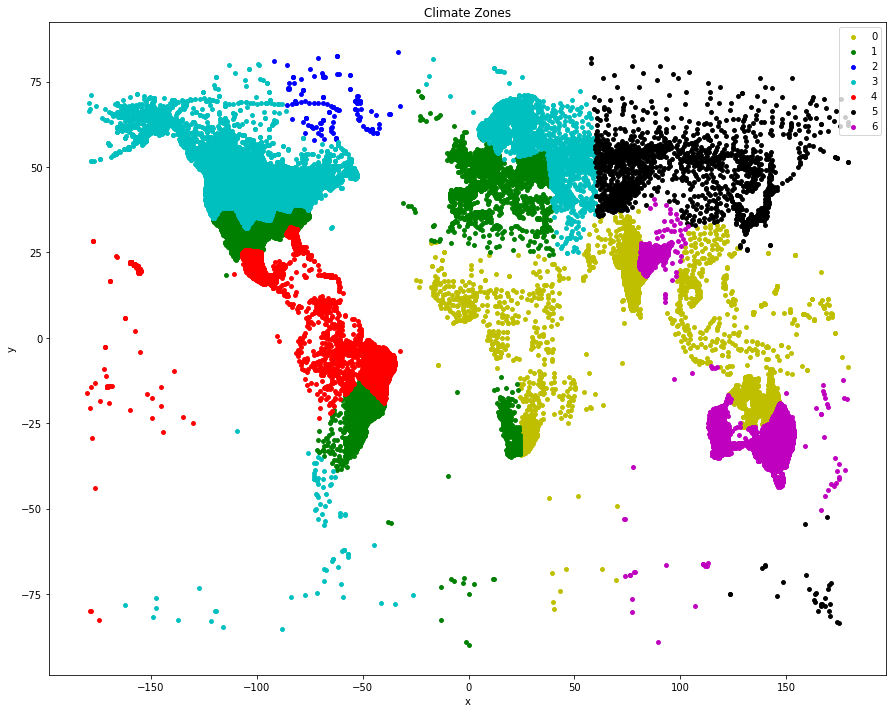

In [ ]:
'''
Representing clusters using scatter plot
'''
import matplotlib.pyplot as plt
import numpy as np

print(zones.count())
stations = predictions.select("id","lat","long",col("prediction").alias("cluster"))
printzoneDf = zones.select("cluster","prediction").join(stations,["cluster"]).cache()
print(printzoneDf.count())
x1 = printzoneDf.select("long").collect()
x = [float(row.long) for row in x1]
x = np.array(x)
print(x)
y1 = printzoneDf.select("lat").collect()
y = [float(row.lat) for row in y1]
y = np.array(y)
print(y)
z1 = printzoneDf.select("prediction").collect()
z = [int(row.prediction) for row in z1]
z = np.array(z)
print(z)

cdict = {0:'y',1:'g',2:'b',3:'c',4:'r',5:'k',6:'m'}

plt.figure(figsize=(15, 12))
plt.xlabel('x')
plt.ylabel('y')
plt.title('Climate Zones')
for group in np.unique(z):
  indexes = np.where(z == group)
  plt.scatter(x[indexes],y[indexes], label=group , c=cdict[group], s=15, marker="o")
plt.legend(loc=1, prop={'size': 10})
plt.show()